## Bottle Cap Color Detection for YOLOv8

This project aims to classify the color of bottle caps into three categories: **light_blue**, **dark_blue**, and **others** (for non-blue caps). The ultimate goal is to prepare a dataset suitable for training a YOLOv8 object detection model. The process involves several key steps:

1.  **Initial Data Exploration**: Analyzing the raw dataset.
2.  **Improved Color Re-labeling**: Using an OpenCV-based approach to automatically re-label cap colors, enhancing accuracy over initial manual labels.
3.  **Data Augmentation**: Expanding the dataset size and variability using various image transformations.
4.  **Dataset Splitting**: Organizing the augmented data into train, validation, and test sets in YOLO format.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("/content/data/raw")

### 1. Initial Data Exploration

This phase involved understanding the initial dataset structure and contents. It included:

*   Loading image and label files from the `/content/data/raw` directory.
*   Printing basic statistics such as the total number of images, labels, and objects.
*   Calculating the average number of objects per image.
*   Identifying unique class IDs present in the initial labels (which were all `0`).
*   Visualizing a sample of images with their original bounding boxes and labels to get a qualitative understanding of the data.

The initial exploration confirmed the presence of images and corresponding YOLO-format labels, but also highlighted the need for more granular color classification beyond a single class.

In [ ]:
image_files = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))
label_files = list(data_dir.glob("*.txt"))

print(f"📊 Dataset Info:")
print(f"   Images: {len(image_files)}")
print(f"   Labels: {len(label_files)}")



📊 Dataset Info:
   Images: 12
   Labels: 12


### 2. Improved Color Re-labeling

To address the need for specific cap color classification (light blue, dark blue, others), an improved color detection algorithm was implemented using OpenCV and HSV color space analysis. This step involved:

*   **`detect_color_improved` function**: This core function takes an image ROI (Region of Interest) of a cap and classifies its color based on fine-tuned HSV ranges for light blue and dark blue. It also includes logic to differentiate non-blue colors ('others') and uses mean HSV values for more robust classification.
*   **`relabel_dataset_improved` function**: This orchestrates the re-labeling process across the entire dataset. For each cap bounding box in the original labels, it extracts the ROI, applies the `detect_color_improved` function, and generates new YOLO-format labels with updated class IDs (0 for light_blue, 1 for dark_blue, 2 for others).
*   **Visualization**: The process includes saving visual examples of re-labeled images, where bounding boxes are colored according to their new class (Cyan for light blue, Blue for dark blue, Green for others).
*   **Class Distribution Analysis**: A summary of the new class distribution (light_blue, dark_blue, others) is provided to show the breakdown of detected colors across the dataset.

This re-labeling step is crucial for creating a dataset that accurately reflects the desired color categories for model training.

In [ ]:
print("\n" + "="*60)
print("ANALYZING LABELS")
print("="*60)

total_objects = 0
all_classes = []
label_stats = {}

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        n_objects = len(lines)
        total_objects += n_objects
        label_stats[label_file.stem] = n_objects

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                all_classes.append(class_id)

print(f"\n📊 Dataset Statistics:")
print(f"   Total images: {len(image_files)}")
print(f"   Total labels: {len(label_files)}")
print(f"   Total objects: {total_objects}")
print(f"   Avg objects/image: {total_objects/len(label_files):.1f}")
print(f"   Classes found: {set(all_classes)}")


ANALYZING LABELS

📊 Dataset Statistics:
   Total images: 12
   Total labels: 12
   Total objects: 79
   Avg objects/image: 6.6
   Classes found: {0}



CREATING VISUALIZATION
✅ Plotted 1/12: raw-250110_dc_s001_b5_5.jpg (5 boxes)
✅ Plotted 2/12: raw-250110_dc_s001_b2_3.jpg (7 boxes)
✅ Plotted 3/12: raw-250110_dc_s001_b2_15.jpg (7 boxes)
✅ Plotted 4/12: raw-250110_dc_s001_b4_1.jpg (5 boxes)
✅ Plotted 5/12: raw-250110_dc_s001_b4_2.jpg (6 boxes)
✅ Plotted 6/12: raw-250110_dc_s001_b3_3.jpg (8 boxes)
✅ Plotted 7/12: raw-250110_dc_s001_b4_3.jpg (7 boxes)
✅ Plotted 8/12: raw-250110_dc_s001_b5_2.jpg (5 boxes)
✅ Plotted 9/12: raw-250110_dc_s001_b3_2.jpg (9 boxes)
✅ Plotted 10/12: raw-250110_dc_s001_b3_4.jpg (10 boxes)
✅ Plotted 11/12: raw-250110_dc_s001_b5_3.jpg (7 boxes)
✅ Plotted 12/12: raw-250110_dc_s001_b2_1.jpg (3 boxes)

💾 Saved visualization: ../data/dataset_overview.png


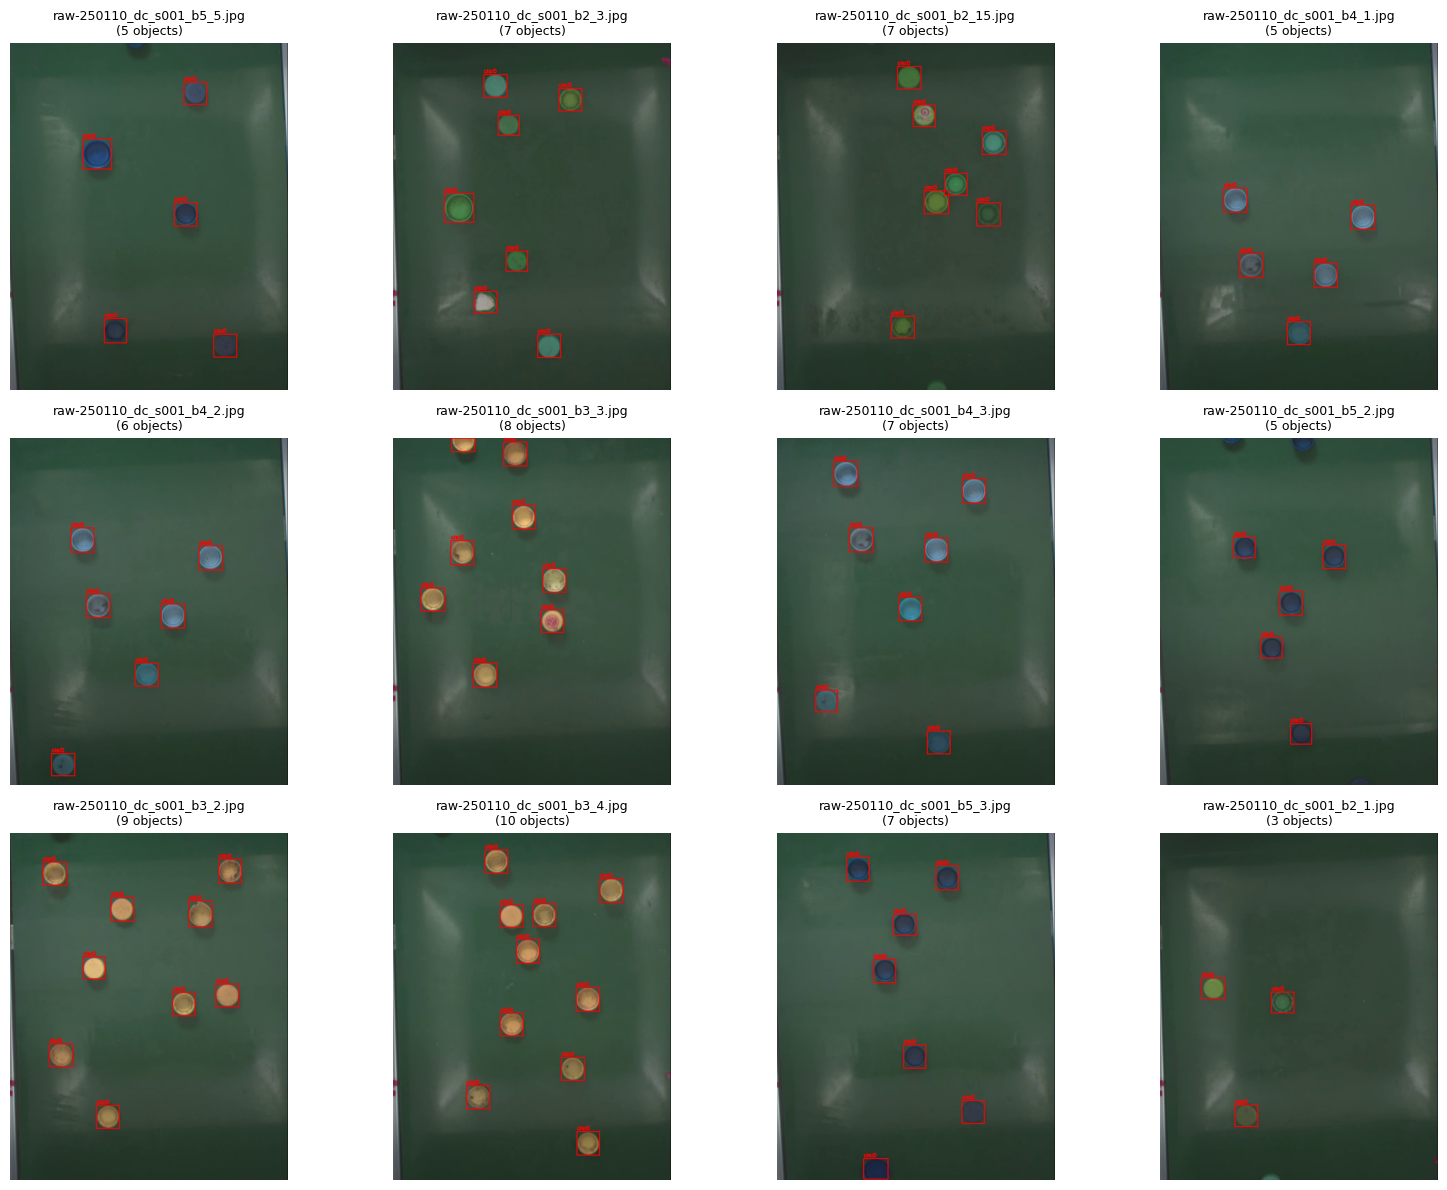


✅ VISUALIZATION COMPLETE
   Successfully plotted: 12/12 images


In [ ]:
print("\n" + "="*60)
print("CREATING VISUALIZATION")
print("="*60)

n_images = min(12, len(image_files))
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten()

successfully_plotted = 0

for idx in range(n_images):
    if idx >= len(image_files):
        axes[idx].axis('off')
        continue

    img_file = image_files[idx]

    img = cv2.imread(str(img_file))

    if img is None:
        print(f"⚠️  Failed to read: {img_file.name}")
        axes[idx].text(0.5, 0.5, f'Failed to load\n{img_file.name}',
                       ha='center', va='center', fontsize=8)
        axes[idx].axis('off')
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    label_file = data_dir / f"{img_file.stem}.txt"

    n_boxes = 0

    if label_file.exists():
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_c, y_c, width, height = map(float, parts[1:5])

                        x1 = int((x_c - width/2) * w)
                        y1 = int((y_c - height/2) * h)
                        x2 = int((x_c + width/2) * w)
                        y2 = int((y_c + height/2) * h)

                        x1 = max(0, min(x1, w))
                        y1 = max(0, min(y1, h))
                        x2 = max(0, min(x2, w))
                        y2 = max(0, min(y2, h))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                        cv2.putText(img, f"cls:{class_id}", (x1, y1-5),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

                        n_boxes += 1
        except Exception as e:
            print(f"⚠️  Error reading label {label_file.name}: {e}")

    axes[idx].imshow(img)
    axes[idx].set_title(f"{img_file.name}\n({n_boxes} objects)", fontsize=9)
    axes[idx].axis('off')

    successfully_plotted += 1
    print(f"✅ Plotted {idx+1}/{n_images}: {img_file.name} ({n_boxes} boxes)")

for idx in range(n_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

output_path = Path("../data/dataset_overview.png")
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization: {output_path}")

plt.show()

print("\n" + "="*60)
print(f"✅ VISUALIZATION COMPLETE")
print("="*60)
print(f"   Successfully plotted: {successfully_plotted}/{n_images} images")

if successfully_plotted == 0:
    print("\n❌ No images were plotted!")
    print("\n🔍 Debugging info:")
    print(f"   Directory: {data_dir.absolute()}")
    print(f"   Directory exists: {data_dir.exists()}")
    print(f"   Images found: {len(image_files)}")

    if len(image_files) > 0:
        test_img = image_files[0]
        print(f"\n   Testing first image: {test_img.name}")
        print(f"   File exists: {test_img.exists()}")
        print(f"   File size: {test_img.stat().st_size if test_img.exists() else 'N/A'} bytes")

        test_read = cv2.imread(str(test_img))
        print(f"   cv2.imread result: {'Success' if test_read is not None else 'Failed'}")

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm


def detect_color_improved(roi: np.ndarray, debug: bool = False) -> int:
    if roi.size == 0 or roi.shape[0] < 5 or roi.shape[1] < 5:
        return 2

    roi_blur = cv2.medianBlur(roi, 5)
    hsv = cv2.cvtColor(roi_blur, cv2.COLOR_BGR2HSV)

    h_mean = np.mean(hsv[:,:,0])
    s_mean = np.mean(hsv[:,:,1])
    v_mean = np.mean(hsv[:,:,2])

    if debug:
        print(f"  Mean HSV: H={h_mean:.1f}, S={s_mean:.1f}, V={v_mean:.1f}")

    light_blue_lower = np.array([85, 40, 80])
    light_blue_upper = np.array([105, 255, 255])

    dark_blue_lower = np.array([100, 60, 40])
    dark_blue_upper = np.array([130, 255, 220])

    light_mask = cv2.inRange(hsv, light_blue_lower, light_blue_upper)
    dark_mask = cv2.inRange(hsv, dark_blue_lower, dark_blue_upper)

    total_pixels = roi.shape[0] * roi.shape[1]
    light_ratio = np.sum(light_mask > 0) / total_pixels
    dark_ratio = np.sum(dark_mask > 0) / total_pixels

    if debug:
        print(f"  Light ratio: {light_ratio:.3f}, Dark ratio: {dark_ratio:.3f}")

    threshold = 0.12

    is_blueish = (h_mean >= 80 and h_mean <= 130 and s_mean > 30)

    if not is_blueish:
        if debug:
            print(f"  → OTHERS (not blueish: H={h_mean:.1f}, S={s_mean:.1f})")
        return 2

    if light_ratio > threshold:
        if dark_ratio > threshold and dark_ratio > light_ratio * 1.5:
            if debug:
                print(f"  → DARK BLUE (more dark than light)")
            return 1
        else:
            if debug:
                print(f"  → LIGHT BLUE (cyan dominant)")
            return 0

    elif dark_ratio > threshold:
        if debug:
            print(f"  → DARK BLUE (only dark detected)")
        return 1

    else:
        if h_mean < 100:
            if debug:
                print(f"  → LIGHT BLUE (H < 100)")
            return 0
        else:
            if debug:
                print(f"  → DARK BLUE (H >= 100)")
            return 1


def relabel_dataset_improved(
    data_dir: Path,
    output_dir: Path,
    visualize: bool = True,
    debug_first_n: int = 0
):
    output_dir.mkdir(parents=True, exist_ok=True)

    if visualize:
        viz_dir = output_dir / "visualizations"
        viz_dir.mkdir(exist_ok=True)

    image_files = sorted(list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png")))

    class_counts = {0: 0, 1: 0, 2: 0}
    class_names = {0: "light_blue", 1: "dark_blue", 2: "others"}

    color_map = {
        0: (255, 255, 0),
        1: (255, 0, 0),
        2: (0, 200, 0)
    }

    print("="*60)
    print("IMPROVED COLOR RE-LABELING")
    print("="*60)

    debug_count = 0

    for img_file in tqdm(image_files, desc="Processing"):
        label_file = data_dir / f"{img_file.stem}.txt"

        if not label_file.exists():
            continue

        image = cv2.imread(str(img_file))
        if image is None:
            continue

        h, w = image.shape[:2]

        with open(label_file, 'r') as f:
            lines = f.readlines()

        new_labels = []
        viz_img = image.copy() if visualize else None

        if debug_first_n > 0 and debug_count < debug_first_n:
            print(f"\n📷 Image: {img_file.name}")

        for cap_idx, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            x_c, y_c, width, height = map(float, parts[1:5])

            x1 = int((x_c - width/2) * w)
            y1 = int((y_c - height/2) * h)
            x2 = int((x_c + width/2) * w)
            y2 = int((y_c + height/2) * h)

            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            roi = image[y1:y2, x1:x2]

            debug_this = (debug_first_n > 0 and debug_count < debug_first_n)
            if debug_this:
                print(f"  Cap {cap_idx+1}:")

            new_class = detect_color_improved(roi, debug=debug_this)
            class_counts[new_class] += 1

            new_labels.append(f"{new_class} {' '.join(parts[1:])}\n")

            if visualize and viz_img is not None:
                cv2.rectangle(viz_img, (x1, y1), (x2, y2), color_map[new_class], 2)

                label_text = class_names[new_class]
                (text_w, text_h), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
                )
                cv2.rectangle(
                    viz_img,
                    (x1, y1 - text_h - 8),
                    (x1 + text_w + 4, y1),
                    color_map[new_class],
                    -1
                )
                cv2.putText(
                    viz_img, label_text, (x1 + 2, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2
                )

        if debug_first_n > 0 and debug_count < debug_first_n:
            debug_count += 1

        with open(output_dir / f"{img_file.stem}.txt", 'w') as f:
            f.writelines(new_labels)

        if visualize and viz_img is not None:
            cv2.imwrite(str(viz_dir / img_file.name), viz_img)

    print("\n" + "="*60)
    print("✅ IMPROVED RE-LABELING COMPLETE")
    print("="*60)
    print(f"\n📊 Class Distribution:")
    total = sum(class_counts.values())
    for class_id, count in class_counts.items():
        pct = count / total * 100 if total > 0 else 0
        print(f"   {class_names[class_id]:12s}: {count:3d} ({pct:.1f}%)")

    print(f"\n📁 Outputs:")
    print(f"   New labels: {output_dir}")
    if visualize:
        print(f"   Visualizations: {viz_dir}")

    return class_counts


if __name__ == "__main__":
    data_dir = Path("/content/data/raw")
    output_dir = Path("/content/data/processed/labels_v2")

    print("Running improved re-labeling with debug output...\n")

    stats = relabel_dataset_improved(
        data_dir=data_dir,
        output_dir=output_dir,
        visualize=True,
        debug_first_n=2
    )

Running improved re-labeling with debug output...

IMPROVED COLOR RE-LABELING


Processing: 100%|██████████| 12/12 [00:00<00:00, 94.35it/s]


📷 Image: raw-250110_dc_s001_b2_1.jpg
  Cap 1:
  Mean HSV: H=62.7, S=83.6, V=82.9
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=62.7, S=83.6)
  Cap 2:
  Mean HSV: H=44.3, S=68.9, V=78.8
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=44.3, S=68.9)
  Cap 3:
  Mean HSV: H=49.2, S=104.4, V=113.3
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=49.2, S=104.4)

📷 Image: raw-250110_dc_s001_b2_15.jpg
  Cap 1:
  Mean HSV: H=56.5, S=109.2, V=94.7
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=56.5, S=109.2)
  Cap 2:
  Mean HSV: H=61.2, S=79.7, V=72.7
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=61.2, S=79.7)
  Cap 3:
  Mean HSV: H=65.8, S=106.6, V=96.1
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=65.8, S=106.6)
  Cap 4:
  Mean HSV: H=46.6, S=115.5, V=96.6
  Light ratio: 0.000, Dark ratio: 0.000
  → OTHERS (not blueish: H=46.6, S=115.5)
  Cap 5:
  Mean HSV: H=48.7, S=105.7, V

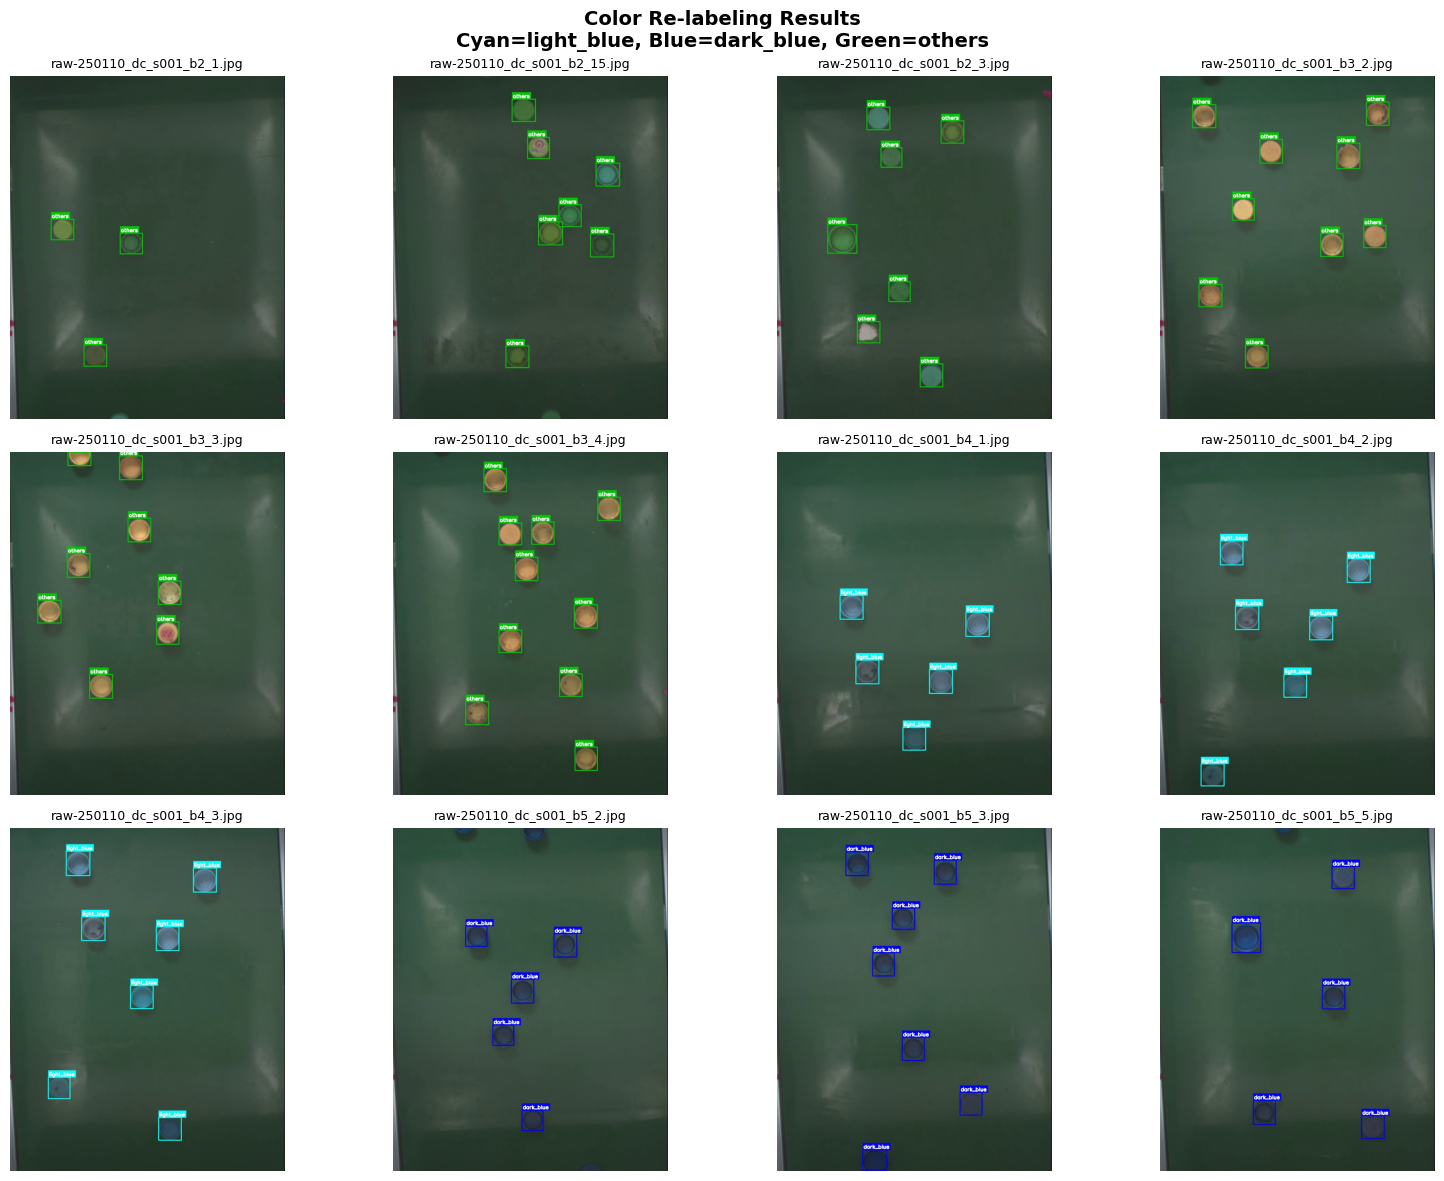

In [ ]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

viz_dir = Path("/content/data/processed/labels_v2/visualizations")
viz_images = sorted(list(viz_dir.glob("*.jpg")) + list(viz_dir.glob("*.png")))

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, img_file in enumerate(viz_images[:12]):
    img = cv2.imread(str(img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img)
    axes[idx].set_title(img_file.name, fontsize=9)
    axes[idx].axis('off')

plt.suptitle("Color Re-labeling Results\nCyan=light_blue, Blue=dark_blue, Green=others",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3. Data Augmentation

To enhance the robustness and generalization capabilities of the future YOLOv8 model, data augmentation techniques were applied. This helps in increasing the effective size of the dataset and exposing the model to a wider variety of image conditions.

*   **Target Size**: The goal was to reach approximately 200 images by generating multiple augmented versions of each original image.
*   **Augmentation Pipeline**: The `albumentations` library was used to apply a series of lightweight and color-preserving transformations, including:
    *   Horizontal Flip
    *   Vertical Flip
    *   Small Affine Transformations (scale, rotation)
    *   Slight Hue Shift
    *   Random Brightness/Contrast adjustments
    *   Light Blur
    *   Light Gaussian Noise
*   **Bounding Box Handling**: Crucially, the augmentation pipeline ensures that bounding box coordinates are correctly transformed along with the images, maintaining the integrity of the labels.
*   **Output**: Augmented images and their corresponding updated YOLO labels are saved to the `/content/data/augmented_relabeled` directory.

In [ ]:
import cv2
import albumentations as A
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm

input_img_dir = Path("/content/data/raw")
input_lbl_dir = Path("/content/data/processed/labels_v2")

output_dir = Path("/content/data/augmented_relabeled")
target_total_images = 200

if output_dir.exists():
    shutil.rmtree(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

if not input_lbl_dir.exists():
    print(f"❌ Error: Folder label tidak ditemukan di {input_lbl_dir}")
    print("   Pastikan Anda sudah menjalankan 'relabel.ipynb' sampai selesai.")
else:
    image_files = list(input_img_dir.glob("*.jpg")) + list(input_img_dir.glob("*.png"))
    current_count = len(image_files)

    if current_count == 0:
        print("❌ Tidak ada gambar di folder raw!")
    else:
        augs_per_image = int((target_total_images - current_count) / current_count) + 1

        print(f"📊 Dataset Asli: {current_count} gambar")
        print(f"📂 Label Source: {input_lbl_dir}")
        print(f"🎯 Target Total: ~{target_total_images}")
        print(f"⚙️ Generate {augs_per_image} variasi per gambar...\n")

        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Affine(scale=(1.0, 1.15), rotate=(-20, 20), p=0.7),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=0, val_shift_limit=0, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Blur(blur_limit=3, p=0.2),
            A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
        ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.3, label_fields=['class_labels']))

        total_saved = 0

        for img_path in tqdm(image_files, desc="Augmenting"):
            txt_filename = f"{img_path.stem}.txt"
            src_txt_path = input_lbl_dir / txt_filename

            shutil.copy(img_path, output_dir / img_path.name)
            if src_txt_path.exists():
                shutil.copy(src_txt_path, output_dir / txt_filename)
            total_saved += 1

            image = cv2.imread(str(img_path))
            if image is None: continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            bboxes = []
            class_labels = []

            if src_txt_path.exists():
                with open(src_txt_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            cls_id = int(parts[0])
                            coords = [float(x) for x in parts[1:5]]
                            bboxes.append(coords)
                            class_labels.append(cls_id)

            for i in range(augs_per_image):
                try:
                    if len(bboxes) > 0:
                        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                        aug_img = augmented['image']
                        aug_bboxes = augmented['bboxes']
                        aug_labels = augmented['class_labels']
                    else:
                        augmented = transform(image=image, bboxes=[], class_labels=[])
                        aug_img = augmented['image']
                        aug_bboxes = []
                        aug_labels = []

                    aug_filename = f"aug_{i}_{img_path.stem}.jpg"
                    aug_txtname = f"aug_{i}_{img_path.stem}.txt"

                    cv2.imwrite(str(output_dir / aug_filename), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

                    if len(aug_bboxes) > 0:
                        with open(output_dir / aug_txtname, 'w') as f:
                            for cls, bbox in zip(aug_labels, aug_bboxes):
                                xc, yc, w, h = [max(0.0, min(1.0, val)) for val in bbox]
                                f.write(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

                    total_saved += 1

                except Exception as e:
                    pass

        print(f"\n✅ Selesai! Dataset augmentasi tersimpan di: {output_dir}")
        print(f"📈 Total gambar sekarang: {total_saved}")

/tmp/ipython-input-824311387.py:43: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),


📊 Dataset Asli: 12 gambar
📂 Label Source: /content/data/processed/labels_v2
🎯 Target Total: ~200
⚙️ Generate 16 variasi per gambar...



Augmenting: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


✅ Selesai! Dataset augmentasi tersimpan di: /content/data/augmented_relabeled
📈 Total gambar sekarang: 204


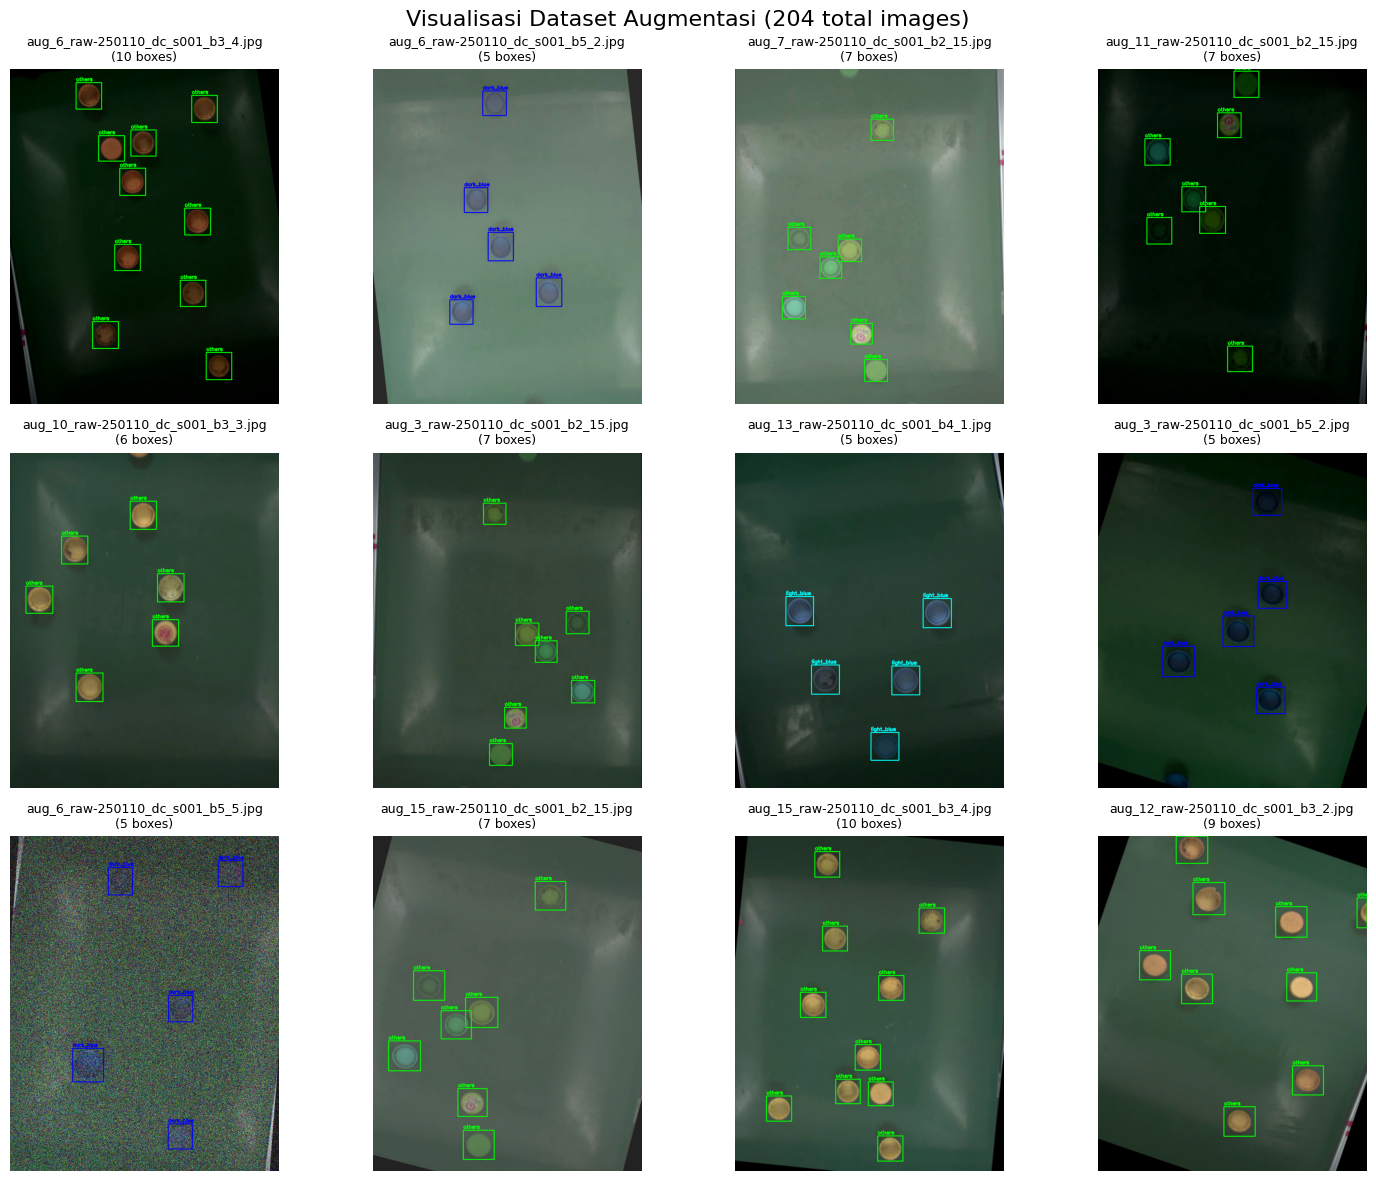

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os

data_dir = Path("/content/data/augmented_relabeled")
num_samples = 12

class_names = {0: "light_blue", 1: "dark_blue", 2: "others"}
colors = {0: (0, 255, 255), 1: (0, 0, 255), 2: (0, 255, 0)}

image_files = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))

if len(image_files) == 0:
    print(f"❌ Tidak ada gambar di {data_dir}")
else:
    samples = random.sample(image_files, min(len(image_files), num_samples))

    cols = 4
    rows = (len(samples) + cols - 1) // cols
    plt.figure(figsize=(15, 4 * rows))
    plt.suptitle(f"Visualisasi Dataset Augmentasi ({len(image_files)} total images)", fontsize=16)

    for i, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        label_path = data_dir / f"{img_path.stem}.txt"
        box_count = 0

        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(float(parts[0]))

                        cx, cy, bw, bh = map(float, parts[1:5])

                        x1 = int((cx - bw/2) * w)
                        y1 = int((cy - bh/2) * h)
                        x2 = int((cx + bw/2) * w)
                        y2 = int((cy + bh/2) * h)

                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)

                        color = colors.get(cls_id, (255, 255, 255))
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                        label_text = class_names.get(cls_id, str(cls_id))
                        cv2.putText(img, label_text, (x1, y1-5),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                        box_count += 1

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{img_path.name}\n({box_count} boxes)", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### 4. Dataset Splitting for YOLO Training

Finally, the augmented and re-labeled dataset is organized into the standard YOLO training format, separating images and labels into training, validation, and test sets.

*   **Directory Structure**: The script creates a `/content/yolo_dataset` directory with subfolders for `train`, `val`, and `test`, each containing `images` and `labels` subdirectories.
*   **Split Ratio**: The dataset is split with a ratio of 70% for training, 20% for validation, and 10% for testing. The images are randomly shuffled before splitting.
*   **File Copying**: Images and their corresponding (augmented and re-labeled) text files are copied to their respective `train`, `val`, or `test` folders.
*   **`data.yaml` Configuration**: A `data.yaml` file is generated, which is essential for YOLOv8 training. This file specifies:
    *   The root path of the dataset.
    *   Relative paths to the `train`, `val`, and `test` image directories.
    *   The number of classes (`nc`: 3).
    *   The names of the classes (`names`: ['light_blue', 'dark_blue', 'others']).

This step prepares the entire dataset in a structured manner, ready for direct ingestion by a YOLOv8 training script.

In [ ]:
image_files = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))
label_files = list(data_dir.glob("*.txt"))

print(f"📊 Dataset Info:")
print(f"   Images: {len(image_files)}")
print(f"   Labels: {len(label_files)}")

📊 Dataset Info:
   Images: 204
   Labels: 204


In [ ]:
import os
import shutil
import yaml
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split


source_dir = Path("/content/data/augmented_relabeled")
output_dir = Path("/content/yolo_dataset")

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1



if output_dir.exists():
    shutil.rmtree(output_dir)

subsets = ['train', 'val', 'test']
for subset in subsets:
    (output_dir / subset / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / subset / 'labels').mkdir(parents=True, exist_ok=True)


image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
image_files = [f for f in source_dir.iterdir() if f.suffix.lower() in image_extensions]

data_info = []

print("🔍 Menganalisis label untuk Stratified Split...")

for img_path in tqdm(image_files, desc="Reading Labels"):
    txt_path = source_dir / f"{img_path.stem}.txt"
    labels = []


    if txt_path.exists() and txt_path.stat().st_size > 0:
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:

                    try:
                        class_id = int(float(parts[0]))
                        labels.append(class_id)
                    except ValueError:
                        continue



    if labels:
        main_class = Counter(labels).most_common(1)[0][0]
    else:
        main_class = -1

    data_info.append({
        'img_path': img_path,
        'txt_path': txt_path,
        'class': main_class
    })


y = [d['class'] for d in data_info]


try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        data_info, y,
        train_size=train_ratio,
        stratify=y,
        random_state=42
    )
except ValueError:
    print("⚠️ Peringatan: Beberapa kelas memiliki jumlah sampel terlalu sedikit untuk stratifikasi sempurna.")
    print("   Beralih ke random split biasa untuk split pertama.")
    X_train, X_temp, y_train, y_temp = train_test_split(data_info, y, train_size=train_ratio, random_state=42)


val_relative_ratio = val_ratio / (val_ratio + test_ratio)


try:
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=val_relative_ratio,
        stratify=y_temp,
        random_state=42
    )
except ValueError:
    print("⚠️ Peringatan: Fallback ke random split untuk split kedua.")
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_relative_ratio, random_state=42)

print(f"\n📊 Hasil Split:")
print(f"   Train: {len(X_train)} gambar")
print(f"   Val  : {len(X_val)} gambar")
print(f"   Test : {len(X_test)} gambar")


splits = {
    'train': X_train,
    'val': X_val,
    'test': X_test
}

for split_name, split_data in splits.items():
    dest_img_dir = output_dir / split_name / 'images'
    dest_lbl_dir = output_dir / split_name / 'labels'

    for item in tqdm(split_data, desc=f"Copying {split_name}"):

        shutil.copy(item['img_path'], dest_img_dir / item['img_path'].name)


        if item['txt_path'].exists():
            shutil.copy(item['txt_path'], dest_lbl_dir / item['txt_path'].name)


yaml_content = {
    'path': str(output_dir),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': 3,
    'names': ['light_blue', 'dark_blue', 'others']
}

yaml_path = output_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"\n✅ Selesai! Dataset Stratified tersimpan di: {output_dir}")
print(f"📄 File konfigurasi: {yaml_path}")

🔍 Menganalisis label untuk Stratified Split...


Reading Labels: 100%|██████████| 204/204 [00:00<00:00, 15367.89it/s]



📊 Hasil Split:
   Train: 142 gambar
   Val  : 41 gambar
   Test : 21 gambar


Copying test: 100%|██████████| 21/21 [00:00<00:00, 2604.70it/s]


✅ Selesai! Dataset Stratified tersimpan di: /content/yolo_dataset
📄 File konfigurasi: /content/yolo_dataset/data.yaml


In [ ]:
import shutil
from google.colab import files
from pathlib import Path

folder_to_download = Path("/content/yolo_dataset")
output_zip_filepath = Path(str(folder_to_download) + ".zip")

print(f"Zipping folder: {folder_to_download}...")
shutil.make_archive(str(folder_to_download), 'zip', folder_to_download.parent, folder_to_download.name)

print(f"\n✅ Folder zipped to: {output_zip_filepath.name}")

print("Initiating download...")
files.download(output_zip_filepath)

print("\nIf the download does not start automatically, please check your browser's download settings or try running the cell again.")

Zipping folder: /content/yolo_dataset...

✅ Folder zipped to: yolo_dataset.zip
Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


If the download does not start automatically, please check your browser's download settings or try running the cell again.
